In [1]:
#imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix

In [123]:
#import data
test = pd.read_csv('titanic/test.csv')
train = pd.read_csv('titanic/train.csv')
gender_submission = pd.read_csv('titanic/gender_submission.csv') #example of submission file

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


array([[<AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

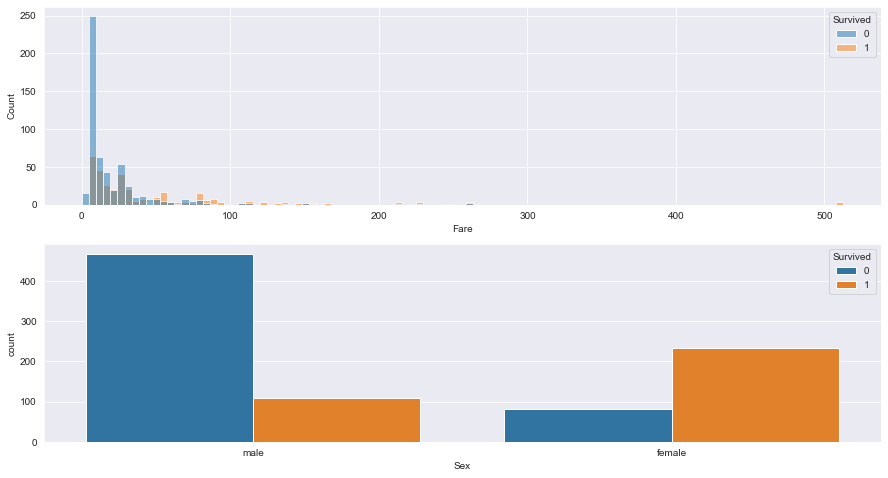

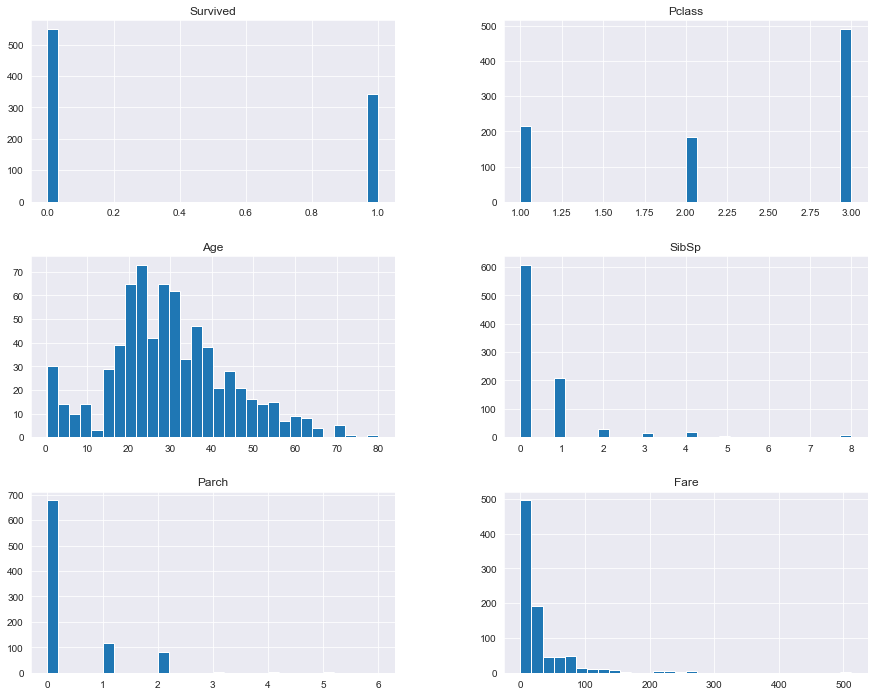

In [118]:
#explore data
train.info()
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,8))
sns.histplot(x = train['Fare'], hue = train['Survived'], ax=axs[0])
sns.countplot(x = train['Sex'], hue = train['Survived'], ax=axs[1])
train.hist(bins =30,figsize=(15,12))

In [219]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [229]:
# data cleaning: impute missing values, scale numerical

#keep same ratio of sex, survived in train and test sets
strat_train_set, strat_test_set = train_test_split(train, test_size=0.2, stratify=train[['Sex', 'Survived']],random_state=42)

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer


num_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
cat_cols = ['Sex']
    
num_pipeline = make_pipeline(
    KNNImputer(n_neighbors=10),
    )

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', handle_unknown='ignore')
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
], remainder='drop')

In [230]:
#test some models to benchmark
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

X_train = strat_train_set.drop('Survived', axis=1)
y_train = strat_train_set['Survived'].copy()

X_test = strat_test_set.drop('Survived', axis=1)
y_test = strat_test_set['Survived'].copy()

#logistic regressions
lin_reg = make_pipeline(preprocessing, LogisticRegression(max_iter=1000))
lin_reg.fit(X_train, y_train)
lin_pred = lin_reg.predict(X_test)
reg_accuracy = accuracy_score(y_test, lin_pred)

#random forest
rfst = make_pipeline(preprocessing, RandomForestClassifier(n_estimators=1000, random_state=1))
rfst.fit(X_train, y_train)
rfst_pred = rfst.predict(X_test)
rfst_accuracy = accuracy_score(y_test, rfst_pred)

#SVM
svm = make_pipeline(preprocessing, SVC(kernel='rbf', C=1, gamma='scale'))
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)

#Gradient Boost
gb = make_pipeline(preprocessing, GradientBoostingClassifier())
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

#KNN
knn = make_pipeline(preprocessing, KNeighborsClassifier(n_neighbors=15))
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)


print('Logistic Regression Accuracy:', reg_accuracy)
print('Random Forest Accuracy:', rfst_accuracy)
print('Support Vector Machine Accuracy:', svm_accuracy)
print('Gradient Boost Accuracy:', gb_accuracy)
print('K Nearest Neighbors Accuracy:', knn_accuracy)


Logistic Regression Accuracy: 0.7932960893854749
Random Forest Accuracy: 0.7821229050279329
Support Vector Machine Accuracy: 0.7094972067039106
Gradient Boost Accuracy: 0.8268156424581006
K Nearest Neighbors Accuracy: 0.6703910614525139


In [155]:
#using kfolds cross validation

from sklearn.model_selection import cross_val_score

#Gradient Boost with cross-validation
gb = make_pipeline(preprocessing, GradientBoostingClassifier())
scores = cross_val_score(gb, X_train, y_train, cv=20)
mean_score = scores.mean()

print('Mean cross-validation accuracy score:', round(mean_score, 4))

#0.8189

#pd.Series(scores).describe()

Mean cross-validation accuracy score: 0.8189


In [250]:
#hyperparamter tuning on gb model only

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


full_pipeline = Pipeline([
    ('preprocessor', preprocessing),
     ('classifier', GradientBoostingClassifier())])

param_distributions = {
    'preprocessor__num__knnimputer__n_neighbors': [5, 10, 20, 30],
    'classifier__n_estimators': [100, 500, 2000],
    'classifier__learning_rate': [0.01, 0.1, 0.5],
    'classifier__max_depth': [3, 8, 50]
}

random_search = RandomizedSearchCV(
    full_pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=5, 
    scoring='accuracy', 
    verbose=2, 
    n_jobs=-1, 
    random_state=42
)

results = random_search.fit(X_train, y_train)

print(results.best_score_)
print(results.best_params_)

# summarize best
print('Best MAE: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.823106470993795
{'preprocessor__num__knnimputer__n_neighbors': 20, 'classifier__n_estimators': 2000, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}
Best MAE: 0.823
Best Config: {'preprocessor__num__knnimputer__n_neighbors': 20, 'classifier__n_estimators': 2000, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}


In [ ]:
#next step is either improve model / pre processing or try ensemble model?

In [247]:
#ensemble method with 3 models

from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier


# define the individual models
model1 = LogisticRegression(max_iter=1000)
model2 = GradientBoostingClassifier()
model3 = RandomForestClassifier()

# create the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', model1), ('gb', model2), ('rf', model3)], voting='soft')

# define the pipelines
num_pipeline = make_pipeline(KNNImputer(n_neighbors=10))

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', handle_unknown='ignore')
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
], remainder='drop')

# combine the pipelines with the ensemble model
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('ensemble_model', ensemble_model)
])

# fit the pipeline on the data
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer(n_neighbors=10))]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Sex'])])),
                ('ensemble_model',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(max_iter=1000)),
                                              ('gb',
                                               GradientBoostingClassifier()),
                                              ('rf', RandomForestClassifier())],
                                  voting='soft'))])

In [249]:
from sklearn.model_selection import RandomizedSearchCV

# define the hyperparameters to search over
param_dist = {
    'preprocessing__num__knnimputer__n_neighbors': [5, 10, 15],
    'ensemble_model__voting': ['hard', 'soft'],
    'ensemble_model__lr__C': [0.1, 1, 10],
    'ensemble_model__gb__max_depth': [None, 5, 10],
    'ensemble_model__rf__n_estimators': [50, 100, 200],
    'ensemble_model__rf__max_depth': [None, 5, 10],
    'ensemble_model__gb__learning_rate': [0.01, 0.1, 0.5]
}

# create the randomized search object
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10, cv=5)

# print the best hyperparameters
results = random_search.fit(X_train, y_train)

print(results.best_score_)
print(results.best_params_)

# summarize best
print('Best MAE: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)

#random_search.get_params().keys() #this shows you which hyperparams you can change


0.8286614793657048
{'preprocessing__num__knnimputer__n_neighbors': 5, 'ensemble_model__voting': 'hard', 'ensemble_model__rf__n_estimators': 100, 'ensemble_model__rf__max_depth': None, 'ensemble_model__lr__C': 0.1, 'ensemble_model__gb__max_depth': 5, 'ensemble_model__gb__learning_rate': 0.01}
Best MAE: 0.829
Best Config: {'preprocessing__num__knnimputer__n_neighbors': 5, 'ensemble_model__voting': 'hard', 'ensemble_model__rf__n_estimators': 100, 'ensemble_model__rf__max_depth': None, 'ensemble_model__lr__C': 0.1, 'ensemble_model__gb__max_depth': 5, 'ensemble_model__gb__learning_rate': 0.01}


dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__preprocessing', 'estimator__ensemble_model', 'estimator__preprocessing__n_jobs', 'estimator__preprocessing__remainder', 'estimator__preprocessing__sparse_threshold', 'estimator__preprocessing__transformer_weights', 'estimator__preprocessing__transformers', 'estimator__preprocessing__verbose', 'estimator__preprocessing__verbose_feature_names_out', 'estimator__preprocessing__num', 'estimator__preprocessing__cat', 'estimator__preprocessing__num__memory', 'estimator__preprocessing__num__steps', 'estimator__preprocessing__num__verbose', 'estimator__preprocessing__num__knnimputer', 'estimator__preprocessing__num__knnimputer__add_indicator', 'estimator__preprocessing__num__knnimputer__copy', 'estimator__preprocessing__num__knnimputer__keep_empty_features', 'estimator__preprocessing__num__knnimputer__metric', 'estimator__preprocessing__num__knnimputer__missing_values', 'estimator__preproc